In [3]:
import numpy as np
import cv2

# קריאה של התמונות
img_left = cv2.imread('im0.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

cam1 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה ימנית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
width = 1920      # רוחב התמונה
height = 1080     # גובה התמונה
ndisp = 176       # מספר ה-disparities המקסימלי

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# הצגת disparity map
cv2.imshow('Disparity', disparity)
cv2.waitKey(0)
cv2.destroyAllWindows()

# מטריצה Q המבוססת על הכיול, לצורך שחזור תלת ממדי
focal_length = cam0[0, 0]  # האורך המוקדי
cx = cam0[0, 2]  # מרכז התמונה בציר x
cy = cam0[1, 2]  # מרכז התמונה בציר y

Q = np.float32([[1, 0, 0, -cx],
                [0, -1, 0, cy],
                [0, 0, 0, focal_length],
                [0, 0, 1 / baseline, (doffs - cx) / baseline]])

# שחזור תלת ממדי
points_3d = cv2.reprojectImageTo3D(disparity, Q)

# סינון נקודות רעש ויצירת ענן נקודות
mask = disparity > disparity.min()
points_3d = points_3d[mask]

# הצגת חלק מהנקודות להמחשה
print(points_3d[:10])


[[ -331.05008  -399.0611  -1293.4775 ]
 [ -331.8538   -399.13046 -1293.7023 ]
 [ -332.57108  -399.0958  -1293.5898 ]
 [ -333.31723  -399.0958  -1293.5898 ]
 [ -334.09238  -399.13046 -1293.7023 ]
 [ -334.9259   -399.23456 -1294.0397 ]
 [ -336.4479   -399.26926 -1294.1522 ]
 [ -363.22543  -399.16516 -1293.8148 ]
 [ -363.8768   -399.0611  -1293.4775 ]
 [ -364.49615  -398.92245 -1293.0281 ]]


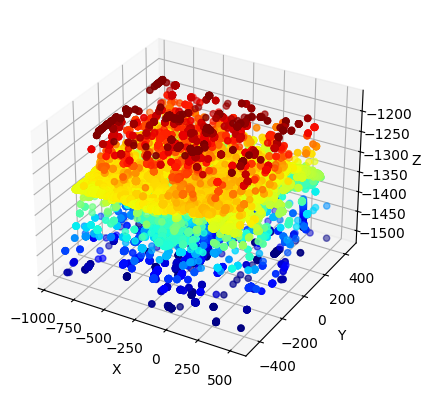

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# קריאה של התמונות
img_left = cv2.imread('im0.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

cam1 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה ימנית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
width = 1920      # רוחב התמונה
height = 1080     # גובה התמונה
ndisp = 176       # מספר ה-disparities המקסימלי, עוגל ל-176 (מתחלק ב-16)

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# הצגת disparity map
cv2.imshow('Disparity', disparity)
cv2.waitKey(0)
cv2.destroyAllWindows()

# מטריצה Q המבוססת על הכיול, לצורך שחזור תלת ממדי
focal_length = cam0[0, 0]  # האורך המוקדי
cx = cam0[0, 2]  # מרכז התמונה בציר x
cy = cam0[1, 2]  # מרכז התמונה בציר y

Q = np.float32([[1, 0, 0, -cx],
                [0, -1, 0, cy],
                [0, 0, 0, focal_length],
                [0, 0, 1 / baseline, (doffs - cx) / baseline]])

# שחזור תלת ממדי
points_3d = cv2.reprojectImageTo3D(disparity, Q)

# יצירת מסכה שתשמור רק על נקודות בעלות disparity חיובי
mask = disparity > disparity.min()

# החלת המסכה על points_3d ועל תמונת ה-disparity כדי לסנן נקודות לא חוקיות
points_3d = points_3d[mask]
disparity_masked = disparity[mask]

# הצגת הנקודות בתלת ממד באמצעות matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# פירוק הנקודות התלת ממדיות לצירים
x_vals = points_3d[:, 0]
y_vals = points_3d[:, 1]
z_vals = points_3d[:, 2]

# יצירת ענן נקודות
ax.scatter(x_vals, y_vals, z_vals, c=z_vals, cmap='jet', marker='o')

# הגדרות נוספות לגרף
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# הצגת הגרף
plt.show()


In [8]:
import numpy as np
import cv2

# קריאה של התמונות
img_left = cv2.imread('im0.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

cam1 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה ימנית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
ndisp = 176       # מספר ה-disparities המקסימלי

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# הצגת disparity map כ"תמונת עומק"
depth_map = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)  # נורמליזציה לערכי 0-255
depth_map = np.uint8(depth_map)  # המרת המפה לערכים של 8 ביט
depth_colored = cv2.applyColorMap(depth_map, cv2.COLORMAP_JET)  # הוספת צבעים למפת העומק

# הצגת התמונה המשוחזרת
cv2.imshow('Depth Map', depth_colored)
cv2.waitKey(0)
cv2.destroyAllWindows()


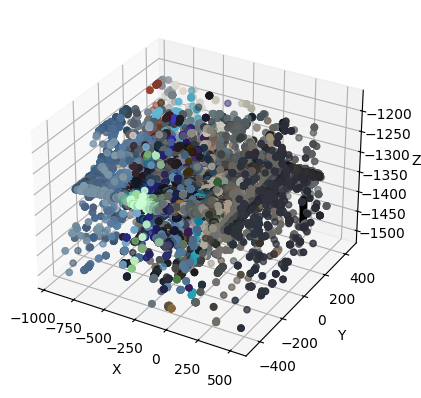

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# קריאה של התמונות בצבע
img_left = cv2.imread('im0.png')
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

cam1 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה ימנית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
width = 1920      # רוחב התמונה
height = 1080     # גובה התמונה
ndisp = 176       # מספר ה-disparities המקסימלי, עוגל ל-176 (מתחלק ב-16)

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY), img_right).astype(np.float32) / 16.0

# הצגת disparity map
cv2.imshow('Disparity', disparity)
cv2.waitKey(0)
cv2.destroyAllWindows()

# מטריצה Q המבוססת על הכיול, לצורך שחזור תלת ממדי
focal_length = cam0[0, 0]  # האורך המוקדי
cx = cam0[0, 2]  # מרכז התמונה בציר x
cy = cam0[1, 2]  # מרכז התמונה בציר y

Q = np.float32([[1, 0, 0, -cx],
                [0, -1, 0, cy],
                [0, 0, 0, focal_length],
                [0, 0, 1 / baseline, (doffs - cx) / baseline]])

# שחזור תלת ממדי
points_3d = cv2.reprojectImageTo3D(disparity, Q)

# יצירת מסכה שתשמור רק על נקודות בעלות disparity חיובי
mask = disparity > disparity.min()

# החלת המסכה על הנקודות ועל תמונת הצבע
points_3d = points_3d[mask]
colors = img_left[mask]

# פירוק הנקודות התלת ממדיות לצירים
x_vals = points_3d[:, 0]
y_vals = points_3d[:, 1]
z_vals = points_3d[:, 2]

# הצגת הנקודות בתלת ממד עם הצבעים המקוריים
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals, c=colors.reshape(-1, 3) / 255, marker='o')

# הגדרות נוספות לגרף
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# הצגת הגרף
plt.show()


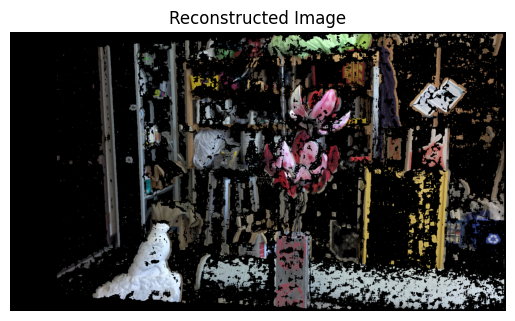

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# קריאה של התמונות בצבע
img_left = cv2.imread('im0.png')
img_right = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)

# פרמטרים מתוך קובץ הכיול (calib.txt)
cam0 = np.array([[1733.74, 0, 792.27], 
                 [0, 1733.74, 541.89], 
                 [0, 0, 1]])  # מטריצת כיול של מצלמה שמאלית

doffs = 0         # הפרש מרכזי תמונות
baseline = 536.62  # בסיס בין המצלמות
width = 1920      # רוחב התמונה
height = 1080     # גובה התמונה
ndisp = 176       # מספר ה-disparities המקסימלי

# יצירת אובייקט StereoBM לחישוב disparity
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=15)

# חישוב disparity map
disparity = stereo.compute(cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY), img_right).astype(np.float32) / 16.0

# מטריצה Q המבוססת על הכיול, לצורך שחזור תלת ממדי
focal_length = cam0[0, 0]  # האורך המוקדי
cx = cam0[0, 2]  # מרכז התמונה בציר x
cy = cam0[1, 2]  # מרכז התמונה בציר y

Q = np.float32([[1, 0, 0, -cx],
                [0, -1, 0, cy],
                [0, 0, 0, focal_length],
                [0, 0, 1 / baseline, (doffs - cx) / baseline]])

# שחזור תלת ממדי
points_3d = cv2.reprojectImageTo3D(disparity, Q)

# יצירת מסכה שתשמור רק על נקודות בעלות disparity חיובי
mask = disparity > disparity.min()

# יצירת התמונה המפוקסת
reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

# שליפת הצבעים מהתמונה השמאלית
img_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
for y in range(height):
    for x in range(width):
        if mask[y, x]:
            # קבלת הצבעים מתוך התמונה השמאלית
            reconstructed_image[y, x] = img_left_rgb[y, x]

# הצגת התמונה המשוחזרת
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()
